# Clustering cryptopunks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tarfile
import urllib

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import Normalizer

from kneed import KneeLocator

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import GridSearchCV


import mysql.connector

In [2]:
# Connect to the new database
#mydb = mysql.connector.connect(
#  host="localhost",
#  user="cecilia",
#  password="cecilia",
#  database="cryptopunks"
#)

#mycursor = mydb.cursor()



In [3]:
df_cp = pd.read_csv('ventas_por_tipo_atributo_y_fecha.csv')


df_cp = df_cp.iloc[:,1:]


In [4]:
# Elimino los cp que no tienen ninguna venta
df_raw = df_cp[pd.notna(df_cp.fecha)].reset_index(drop=True).copy()
df_raw.drop('fecha', inplace= True, axis=1)


In [5]:
# Elegir usar Male / Female o Ape / Alien / Zombie
df_mask = (df_raw['Ape/Ape'] != 1 ) & (df_raw['Alien/Alien'] != 1 ) & (df_raw['Zombie/Zombie'] != 1 )
#df_mask = (df_raw['Ape/Ape'] == 1 ) | (df_raw['Alien/Alien'] == 1 ) | (df_raw['Zombie/Zombie'] == 1 )

#df_mask = (df_raw['Male/Dark'] == 1 ) | (df_raw['Female/Dark'] == 1 )

df = df_raw[df_mask]
df = df.groupby('id_cryptopunk').sum()
df.reset_index(inplace=True)

In [6]:
#df['dio_beneficio'] = df.apply(lambda row: 1 if row.beneficio > 0 else 0, axis=1)
df['sin_perdida'] = df.apply(lambda row: 1 if ((row.beneficio > 0) | (row.cant_ventas ==1)) else 0, axis=1)

In [7]:
df

,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Albino,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,cant_attr,beneficio,cant_ventas,sin_perdida
0,0.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2822.0,3,2502.0,3,1
1,1.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,36305.0,2,36198.0,3,1
2,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,234.0,3,49.0,3,1
3,33.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,105.0,1,0.0,1,1
4,53.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,432676.0,2,406064.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,9980.0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,182376.0,4,182306.0,6,1
6505,9982.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,403557.0,3,-77531.0,2,0
6506,9989.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,140.0,3,0.0,1,1
6507,9990.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0.0,2,-44981.0,2,0


In [8]:
# Antes de outliers
df[df['Cowboy Hat']==1]

,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Albino,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,cant_attr,beneficio,cant_ventas,sin_perdida
122,516.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,115.0,3,0.0,1,1
212,735.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,451104.0,4,344309.0,2,1
265,862.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,183526.0,4,51007.0,2,1
280,915.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,379593.0,2,282077.0,2,1
293,943.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,142824.0,1,-21668.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6170,9496.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,140340.0,3,57322.0,3,1
6307,9679.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,28.0,2,0.0,1,1
6313,9688.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,30.0,2,0.0,1,1
6372,9774.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,292915.0,4,0.0,1,1


In [9]:
# Copio del S09 una función para contar outliers
def contar_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    outliers_bool = (df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))
    outliers = outliers_bool.sum(axis=0)
    return outliers

print('Outliers de valor_$:', contar_outliers(df['valor_$']))

Outliers de valor_$: 146


In [10]:
    Q1 = df['valor_$'].quantile(0.25)
    Q3 = df['valor_$'].quantile(0.75)
    IQR = Q3 - Q1
    
    no_outliers_bool = (df['valor_$'] > (Q1 - 1.5 * IQR)) &(df['valor_$'] < (Q3 + 1.5 * IQR))
    df = df[no_outliers_bool].reset_index(drop=True).copy()
    #df

In [11]:
df['valor_$'].describe()

count      6363.000000
mean     135367.954110
std      158334.704665
min           0.000000
25%        2232.500000
50%       58605.000000
75%      233979.500000
max      625973.000000
Name: valor_$, dtype: float64

In [12]:
df[(df['Cowboy Hat']==1) & (df['sin_perdida']==0)]
#d<f[(df['sin_perdida']==1)]

,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Albino,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,cant_attr,beneficio,cant_ventas,sin_perdida
278,943.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,142824.0,1,-21668.0,2,0
769,1846.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,66.0,2,-43.0,2,0
1744,3256.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,225.0,1,-32.0,2,0
3893,6360.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,93798.0,4,-20411.0,2,0


In [13]:
correlac = df.corr()
#mascara = np.triu(correlac)
#sns.heatmap(correlac, vmax=1, vmin=-1, square=True, mask=mascara, annot = True);
#plt.show()
#correlac

In [14]:
df_raw = df.copy()
df.drop(['valor_$'], inplace= True, axis=1)
df.drop(['sin_perdida'], inplace= True, axis=1)
df.drop(['cant_ventas'], inplace= True, axis=1)
df.drop(['Big Shades', 'Blue Eye Shadow', 'Chinstrap', 'Hot Lipstick', 'Purple Hair'], inplace= True, axis=1)

## Estandarizar

In [15]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(df)

## Aplicar PCA para reducir variables

In [16]:
# apply PCA


pca = PCA(n_components=.95, random_state=42)  # keep 95% variability
X_PCA = pca.fit_transform(X_sc)

pd.DataFrame(X_PCA)


,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,3.002361,0.238458,0.250167,0.160164,-1.470283,0.992780,-0.789453,0.450185,0.043610,-0.174013,...,1.939068,-0.267123,-0.310916,0.300001,0.345286,-0.822450,-0.386436,0.529036,2.625919,1.212736
1,-1.018352,-1.416041,-0.423241,2.638150,-0.782745,0.218651,0.104761,-0.462847,-0.194791,0.589989,...,0.412087,-0.005296,0.445891,-0.009307,-1.266952,-0.589045,1.266282,0.787033,0.832339,1.060705
2,1.978413,-1.267976,0.028712,-0.315363,-0.256113,0.071938,1.386746,0.283225,-2.966441,-2.397409,...,-1.674867,-1.510941,-1.688298,-0.446552,0.374199,0.204884,0.387162,-0.061714,-1.802826,-0.345998
3,-0.972625,-2.549220,-0.102370,-1.941224,-0.863476,0.306898,0.446254,0.202510,-0.506452,-1.024229,...,-0.581621,0.588056,-0.199465,0.035805,-0.429916,0.077627,0.130149,0.063836,-0.204397,0.766050
4,1.769207,-2.093935,0.057175,-0.032360,1.679987,-0.272621,0.390049,0.720180,-0.527348,0.305021,...,0.680228,-1.172208,1.006057,-0.587222,1.254351,-1.331012,0.535325,-0.802551,0.564240,1.712810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,2.892090,2.161543,0.028410,0.490884,-0.017738,-1.025284,-1.154378,-2.323759,0.984173,-0.231248,...,-0.403195,0.541358,-1.278975,1.559611,1.118530,1.928276,-0.464207,-0.147670,2.439236,-0.300354
6359,0.756178,1.057001,0.318426,-0.891833,2.750421,1.074808,-0.070945,0.043046,0.291952,-0.437857,...,0.381344,0.638161,-1.347753,0.395989,-1.017102,-1.066108,0.271752,-1.658194,-0.784349,0.565344
6360,1.979910,0.095685,0.242921,0.201151,-0.047334,-1.697821,1.295260,-0.843628,-1.680015,-1.405476,...,-1.795240,-0.517320,-2.343100,0.361504,0.440025,0.199663,1.175406,1.547580,-2.347835,-1.190202
6361,-0.449475,-1.060327,0.012583,0.093862,0.516324,-0.598101,-1.170508,-1.527706,-0.696090,0.985931,...,0.174832,-0.079801,0.111371,0.052922,0.107052,0.324105,0.088495,-0.764514,-1.391321,-0.038309


## Clasificar  usando K-means

In [17]:
# Choose a number of clusters (will need to run with different values) 
nro_k=10

# Here´s the model, the parameters were obtained by GridSearch
kmeans = KMeans(
               n_clusters=nro_k,
               init="random",    # el default es random, lo dió el GridSearch
               n_init=10,    # es la cantidad de veces que se inicializa, el default es 10
               max_iter=100,   # máximo de iteraciones
               random_state=42,
           )
kmeans.fit(X_PCA)

KMeans(init='random', max_iter=100, n_clusters=10, random_state=42)

In [18]:
predicted_labels = kmeans.labels_
#predicted_labels

In [19]:
# add the clusters to the original dataframe
df_raw['cluster'] = predicted_labels
df_raw

,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,cant_attr,beneficio,cant_ventas,sin_perdida,cluster
0,0.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2822.0,3,2502.0,3,1,0
1,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,36305.0,2,36198.0,3,1,9
2,14.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,234.0,3,49.0,3,1,0
3,33.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,105.0,1,0.0,1,1,6
4,53.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,432676.0,2,406064.0,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,9980.0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,182376.0,4,182306.0,6,1,0
6359,9982.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,403557.0,3,-77531.0,2,0,0
6360,9989.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,140.0,3,0.0,1,1,0
6361,9990.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,2,-44981.0,2,0,6


In [20]:
# How many elements do the clusters have?
clusters = np.unique(predicted_labels, return_counts=True)
print(clusters)
centroids = kmeans.cluster_centers_
#print(centroids)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1750,  428,   94,  415,  100,  168, 1381,   50, 1009,  968],
      dtype=int64))


In [21]:
#df_ct = df_raw.loc[:, ['id_cryptopunk','cluster']].groupby('cluster').count()

#line, = df_ct.plot(kind='barh')
#line.set_label('Label via method')
#ax.legend()

In [28]:
clu = 7
df_clu =df_raw[df_raw.cluster == clu]
df_clu

,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,cant_attr,beneficio,cant_ventas,sin_perdida,cluster
50,322.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,21298.0,3,16670.0,2,1,7
126,537.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,391166.0,2,0.0,1,1,7
180,684.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,600918.0,4,0.0,1,1,7
198,719.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,325.0,3,0.0,1,1,7
310,1010.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,173045.0,3,144444.0,2,1,7
374,1163.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,146842.0,3,0.0,1,1,7
569,1514.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,422376.0,3,237772.0,2,1,7
675,1694.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,72041.0,3,0.0,1,1,7
873,2015.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,295037.0,3,216323.0,4,1,7
985,2190.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,127687.0,3,52038.0,2,1,7


In [29]:


df_clu.groupby('cant_attr').count()



,id_cryptopunk,3D Glasses,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,Blue Eye Shadow,...,Male/Albino,Male/Dark,Male/Light,Male/Mid,Zombie/Zombie,valor_$,beneficio,cant_ventas,sin_perdida,cluster
cant_attr,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
3,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
4,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [30]:
for col in df_clu:
    contar = (df_clu[col]>0).sum()
    if contar>0:
        print(col, contar)
    

id_cryptopunk 50
3D Glasses 1
Big Shades 2
Black Lipstick 8
Blue Eye Shadow 8
Cigarette 2
Classic Shades 2
Clown Eyes Blue 7
Clown Eyes Green 6
Earring 13
Eye Patch 1
Green Eye Shadow 1
Horned Rim Glasses 3
Hot Lipstick 8
Mole 3
Nerd Glasses 2
Pink With Hat 50
Pipe 1
Purple Eye Shadow 1
Purple Lipstick 12
Regular Shades 3
Silver Chain 2
Spots 1
VR 1
Vape 2
Female/Albino 5
Female/Dark 17
Female/Light 12
Female/Mid 16
valor_$ 50
cant_attr 50
beneficio 36
cant_ventas 50
sin_perdida 50
cluster 50


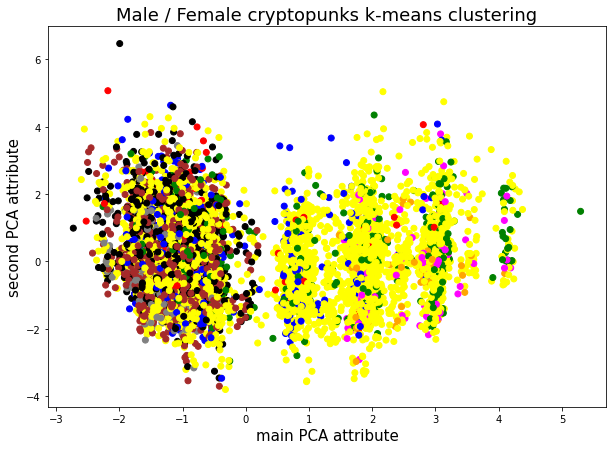

In [25]:
colores=['yellow','green','red','blue','fuchsia', 'grey', 'yellow', 'orange', 'black', 'brown']
asignar=[]
for row in predicted_labels:
     asignar.append(colores[row])
plt.figure(figsize=(10,7))
plt.scatter(X_PCA[:,0],X_PCA[:,1], c=asignar)
#plt.legend(fontsize='small')
plt.xlabel('main PCA attribute', fontsize=15)
plt.ylabel('second PCA attribute', fontsize=15)
plt.title('Male / Female cryptopunks k-means clustering', fontsize=18)
plt.show()

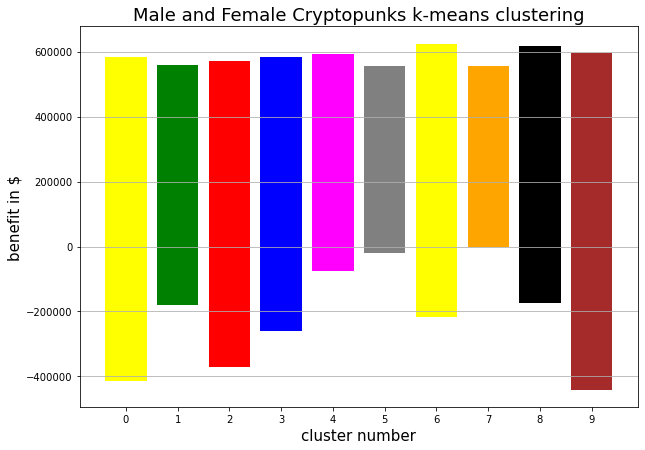

In [26]:
plt.figure(figsize=(10,7))
plt.bar(df_raw['cluster'],df_raw['beneficio'], color=asignar)
#plt.legend(fontsize='small')
plt.xlabel('cluster number', fontsize=15)
plt.ylabel('benefit in $', fontsize=15)
plt.xticks(np.arange(0, nro_k))
plt.title('Male and Female Cryptopunks k-means clustering', fontsize=18)
plt.grid(True, axis='y')
plt.show()

In [27]:
un error

SyntaxError: invalid syntax (<ipython-input-27-d08cd4c05d78>, line 1)

## Calcular el valor de k

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

In [ ]:
# Use SSE (sum of the square error) and silhouette_score to evaluate a good k (number of clusters)
kmeans_kwargs = {
               'init': "k-means++",    # el default es random, este parece facilitar la convergencia
               'n_init': 30,    # es la cantidad de veces que se inicializa, el default es 10
               'max_iter': 200,   # máximo de iteraciones
               'random_state': 42
}

# define the max k-number to evaluate the model
max_range = 7
min_range = 2

# A list holds the SSE values for each k
# Empty lists to hold evaluation metrics
silhouette_scores = []
sse_scores = []
for nro_k in range(min_range, max_range):
    kmeans = KMeans(n_clusters=nro_k, **kmeans_kwargs)
    kmeans.fit(X_PCA)
    sse_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_PCA, kmeans.labels_))


The difference between the cluster is not clear, I don´t see the criteria for the grouping. Could be something that has to do with the origin and the distance...


In [ ]:
model = KMeans()
params = {'n_clusters': range(min_range, max_range), 'init': ["k-means++", "random"],    # el default es random, este parece facilitar la convergencia
               'n_init': [10, 50],    # es la cantidad de veces que se inicializa, el default es 10
               'max_iter': [100],   # máximo de iteraciones
               'random_state': [42] }
grid = GridSearchCV(model, params, cv=10)
grid.fit(df_raw)
grid.best_estimator_.get_params()

In [ ]:
# When the elbow is difficult to identify:
kl = KneeLocator(range(min_range, max_range), sse_scores, curve="convex", direction="decreasing")
k_elbow = kl.elbow
k_elbow

In [ ]:
# Plot the values of the metrics along with the number of clusters
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(
    range(min_range, max_range),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
ax2.plot(range(min_range, max_range), sse_scores, c="#fc4f30", label="SSE")
ax2.plot(k_elbow, sse_scores[k_elbow-2],'ro', markersize=10, label=f'Elbow (k={k_elbow})')

ax1.set_title("Silhouette Coefficient")
ax2.set_title("SSE (sum of sq errors)")
ax1.legend()
ax1.set_xlabel('clusters')
ax1.set_ylabel('silhouette coef')
ax2.legend()
ax2.set_xlabel('clusters')
ax2.set_ylabel('SSE')
fig.suptitle("Clustering Performance\nas a Function of n_components")
fig.tight_layout()


In [ ]:
print('Silhouette scores:', silhouette_scores)
# print('Silhouette score kmeans para k= 4', silhouette_scores[2])
# El mejor valor es cuando se acerca a 1 o a -1
# El valor para k=4 era 0.0622

Another measure can be Calinski-Harabasz score: the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster

In [ ]:
print('Calinski-Harabasz score for k-means clustering:', round(calinski_harabasz_score(X_PCA, kmeans.labels_),2))
# It`s better when the value is lower